# CNN Training

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
project_path = "/content/gdrive/MyDrive/ColabData/emotion_recognition" # the dataset will be loaded from Google Drive

import sys
sys.path.append('/content/gdrive/MyDrive/ColabData')

import numpy as np

Mounted at /content/gdrive


## Pre-processing

<br>

Utility function to plot an image from path

Loading /content/gdrive/MyDrive/ColabData/emotion_recognition/cohn-kanade-images/S010/002/S010_002_00000014.png


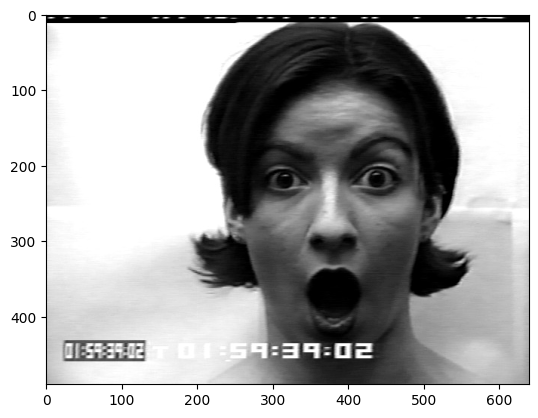

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_gray_image_from_path(path):
    img = mpimg.imread(path)
    imgplot = plt.imshow(img, cmap=plt.cm.gray)
    plt.show()

dir = "S010"
subdir = "002"
frame = "00000014"
path = f"{project_path}/cohn-kanade-images/{dir}/{subdir}/{dir}_{subdir}_{frame}.png"
print(f"Loading {path}")
show_gray_image_from_path(path)

<br>

Utility function to get the emotion label of an image from path

In [ ]:
def get_emotion_from_path(path):
  try:
    with open(path) as f:
      lines = f.readlines()
      return {
          0.0: "neutral",
          1.0: "anger",
          2.0: "contempt",
          3.0: "disgust",
          4.0: "fear",
          5.0: "happy",
          6.0: "sadness",
          7.0: "surprise"
      }[float(lines[0])]

  except:
    return None

path = f"{project_path}/Emotion/{dir}/{subdir}/{dir}_{subdir}_{frame}_emotion.txt"
print(path)
print(get_emotion_from_path(path))

/content/gdrive/MyDrive/ColabData/emotion_recognition/Emotion/S010/002/S010_002_00000014_emotion.txt
surprise


<br>

Utility function to get the Action Units of an image from path

In [ ]:
possible_aus = [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 9.0, 12.0, 14.0, 15.0, 16.0, 20.0, 23.0, 26.0]
one_hot_encoded_label_indices = list(range(len(possible_aus)))

# mapping between AU value and one-hot encoded label index
aus_dict = {k:one_hot_encoded_label_indices[possible_aus.index(k)] for k in possible_aus}
print("AUs dict:", aus_dict, "\n")

def get_aus_from_path(path):
  lab = [0 for _ in range(len(possible_aus))]
  with open(path) as f:
      lines = f.readlines()
      aus = []
      for line in lines:
        line = line.strip().split("   ")
        line = float(line[0])
        if line in aus_dict.keys():   # some AUs are not useful to detect the emotions we are interested in
          idx = aus_dict[line]
          lab[idx] = 1.0
      return np.array(lab)

path = f"{project_path}/FACS/{dir}/{subdir}/{dir}_{subdir}_{frame}_facs.txt"
print(path)
print(get_aus_from_path(path))

AUs dict: {1.0: 0, 2.0: 1, 4.0: 2, 5.0: 3, 6.0: 4, 7.0: 5, 9.0: 6, 12.0: 7, 14.0: 8, 15.0: 9, 16.0: 10, 20.0: 11, 23.0: 12, 26.0: 13} 

/content/gdrive/MyDrive/ColabData/emotion_recognition/FACS/S010/002/S010_002_00000014_facs.txt
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<br>

Utility function to detect the face in an input image

(346, 346, 3)


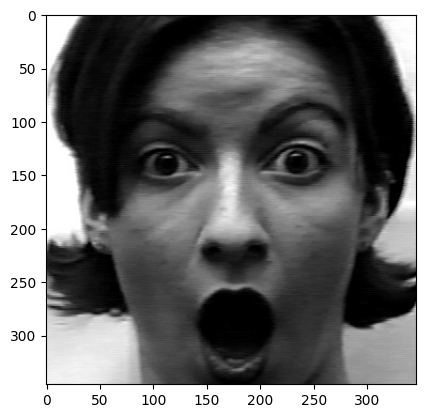

In [ ]:
import cv2
import numpy as np
from PIL import Image

face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def get_face_frame(path, resize_shape=None):
  try:
    frame = cv2.imread(path)        # the original RGB frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # RGB frame converted to grayscale
    faces = face_classifier.detectMultiScale(gray, 1.1, 5, minSize=(40, 40))   # get recognized faces

    if len(faces) == 0: return None

    top, right, bottom, left = faces[0]
    roi = frame[right:right + left, top:top + bottom]

    if resize_shape:
      roi = cv2.resize(roi, resize_shape, interpolation = cv2.INTER_AREA)

    return roi

  except:
    return []


path = f"{project_path}/cohn-kanade-images/{dir}/{subdir}/{dir}_{subdir}_{frame}.png"
face = get_face_frame(path)
print(face.shape)
plt.imshow(face, "gray")
plt.show()

(200, 200, 3)


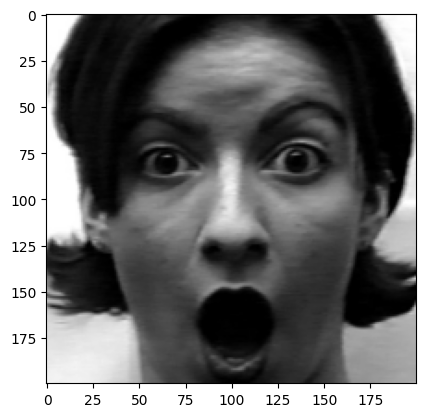

In [ ]:
face = get_face_frame(path, resize_shape=(200,200))
print(face.shape)
plt.imshow(face, "gray")
plt.show()

<br>

Loading the dataset

In [ ]:
import os
from tqdm.auto import tqdm

resize_shape = (200,200)
train_X, train_single_Y, train_multi_Y = [], [], []
#counter = 0

for dir in tqdm(os.listdir(f"{project_path}/cohn-kanade-images")):
  #print(dir)
  #counter += 1   #ToDo: togli
  #if counter > 5: break   #ToDo: togli

  for subdir in os.listdir(f"{project_path}/cohn-kanade-images/{dir}"):
    #print(subdir)
    if not subdir.startswith('.'):
      try:
        emotion_files = os.listdir(f"{project_path}/Emotion/{dir}/{subdir}")
      except:
        continue

      # check if there is the emotion label for these subdir
      if len(emotion_files) > 0:
        path = f"{project_path}/Emotion/{dir}/{subdir}/{emotion_files[0]}"
        emotion_label = get_emotion_from_path(path)

        aus_end_string = emotion_files[0]
        aus_end_string = aus_end_string[:-11] + "facs.txt"
        path = f"{project_path}/FACS/{dir}/{subdir}/{aus_end_string}"
        aus_label = get_aus_from_path(path)

        for frame in os.listdir(f"{project_path}/cohn-kanade-images/{dir}/{subdir}"):
          if frame.endswith(".png"):
            #print("\t", frame)
            path = f"{project_path}/cohn-kanade-images/{dir}/{subdir}/{frame}"
            face = get_face_frame(path, resize_shape)
            if len(face) > 0:
              train_X.append(face)
              train_single_Y.append(emotion_label)
              train_multi_Y.append(aus_label)


train_X = np.array(train_X)
train_single_Y = np.array(train_single_Y)
train_multi_Y = np.array(train_multi_Y)
print(f"Train_X shape: {train_X.shape}")
print(f"Train_single_Y shape: {train_single_Y.shape}")
print(f"Train_multi_Y shape: {train_multi_Y.shape}")

  0%|          | 0/123 [00:00<?, ?it/s]

Train_X shape: (5876, 200, 200, 3)
Train_single_Y shape: (5876,)
Train_multi_Y shape: (5876, 14)


<br>

Saving the pre-processed dataset

In [ ]:
import pickle

with open(f'{project_path}/preprocessed_dataset', 'wb') as f:
  pickle.dump({"X": train_X,
               "single_Y": train_single_Y,
               "multi_Y": train_multi_Y},
              f)

<br>

Reloading the pre-processed dataset

In [ ]:
import pickle

with open(f'{project_path}/preprocessed_dataset', 'rb') as f:
  tmp_dict = pickle.load(f)

train_X = tmp_dict["X"]
train_single_Y = tmp_dict["single_Y"]
train_multi_Y = tmp_dict["multi_Y"]
del tmp_dict

In [ ]:
single_classes = sorted(np.unique(train_single_Y))
print("Emotion classes:", single_classes)
print("Example of AUs label:", train_multi_Y[70])

Emotion classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
Example of AUs label: [0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.]


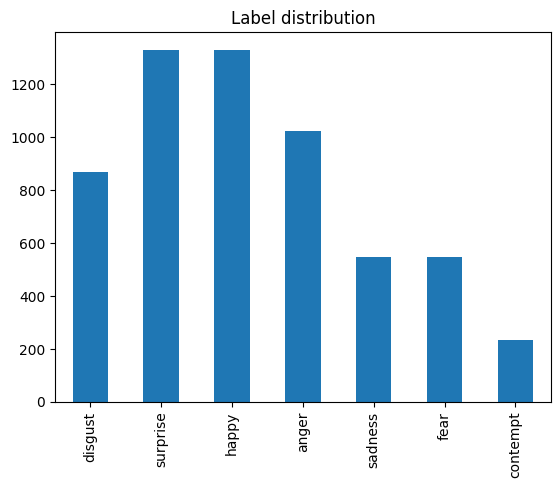

In [ ]:
import pandas as pd

pd.Series(train_single_Y).value_counts(sort=False).plot(kind='bar')
plt.title("Label distribution")
plt.show()

<br>

Loading a pre-trained classifier and perform fine-tuning

In [ ]:
# downgrading tensorflow to save the fine-tuned EfficientNetB0 model
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 54.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing insta

In [ ]:
import keras

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

## Single-output classifier

Building a classifier that only recognize the emotion

In [ ]:
def build_single_output_model(img_shape, num_classes, freeze_weights=False, verbose=0):
    inputs = layers.Input(shape=img_shape)
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze/Unfreeze the pretrained weights
    if freeze_weights:
      model.trainable = freeze_weights
    else:
      # unfreezing the top 20 layers while leaving BatchNorm layers frozen
      for layer in model.layers[-20:]:
          if not isinstance(layer, layers.BatchNormalization):
              layer.trainable = True

    # Attach head
    x = layers.GlobalAveragePooling2D(name="global_pooling")(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=0.2, name="dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")

    if freeze_weights:
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)   # large learning rate
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)   # low learning rate

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    if verbose > 0: print(model.summary())

    return model


img_shape = train_X[0].shape
build_single_output_model(img_shape, num_classes=len(single_classes), freeze_weights=False, verbose=1)

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 200, 200, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_4 (Normalization  (None, 200, 200, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                       

<br>

One-hot encoding the labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
train_single_Y_ohe = enc.fit_transform(train_single_Y.reshape(-1, 1)).toarray()

print(single_classes)
print(train_single_Y[0], "->", train_single_Y_ohe[0])

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
disgust -> [0. 0. 1. 0. 0. 0. 0.]


<br>

Splitting data into Train and Validation sets. Since it's a toy sample, we don't use a test set to check how well the model generalize on unseen data.

In [ ]:
from sklearn.model_selection import train_test_split

X, val_X, Y, val_Y = train_test_split(train_X, train_single_Y_ohe, test_size=0.10, random_state=42)

<br>

Build and train the single output classifier

In [ ]:
model = build_single_output_model(img_shape, num_classes=len(single_classes), freeze_weights=False)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(x=X, y=Y, validation_data=(val_X, val_Y), epochs=100, verbose=1, callbacks=[early_stopping])

Epoch 1/100
166/166 [==============================] - 67s 275ms/step - loss: 1.0540 - accuracy: 0.6348 - val_loss: 1.4083 - val_accuracy: 0.4932
Epoch 2/100
166/166 [==============================] - 44s 265ms/step - loss: 0.4385 - accuracy: 0.8485 - val_loss: 0.4224 - val_accuracy: 0.8605
Epoch 3/100
166/166 [==============================] - 44s 264ms/step - loss: 0.2961 - accuracy: 0.8950 - val_loss: 0.1854 - val_accuracy: 0.9337
Epoch 4/100
166/166 [==============================] - 44s 266ms/step - loss: 0.1950 - accuracy: 0.9359 - val_loss: 0.1494 - val_accuracy: 0.9507
Epoch 5/100
166/166 [==============================] - 44s 264ms/step - loss: 0.1538 - accuracy: 0.9484 - val_loss: 0.1482 - val_accuracy: 0.9354
Epoch 6/100
166/166 [==============================] - 43s 262ms/step - loss: 0.1238 - accuracy: 0.9580 - val_loss: 0.1012 - val_accuracy: 0.9643
Epoch 7/100
166/166 [==============================] - 44s 263ms/step - loss: 0.0974 - accuracy: 0.9658 - val_loss: 0.0793 -

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(val_X)
predictions = np.argmax(predictions, axis=1)
ground_truth = np.argmax(val_Y, axis=1)

print(classification_report(ground_truth, predictions, target_names=single_classes))

              precision    recall  f1-score   support

       anger       0.94      0.99      0.96        95
    contempt       1.00      1.00      1.00        21
     disgust       0.96      0.99      0.97        88
        fear       0.98      0.93      0.96        58
       happy       0.97      0.98      0.98       133
     sadness       0.98      0.93      0.96        61
    surprise       1.00      0.97      0.98       132

    accuracy                           0.97       588
   macro avg       0.98      0.97      0.97       588
weighted avg       0.97      0.97      0.97       588



<Axes: >

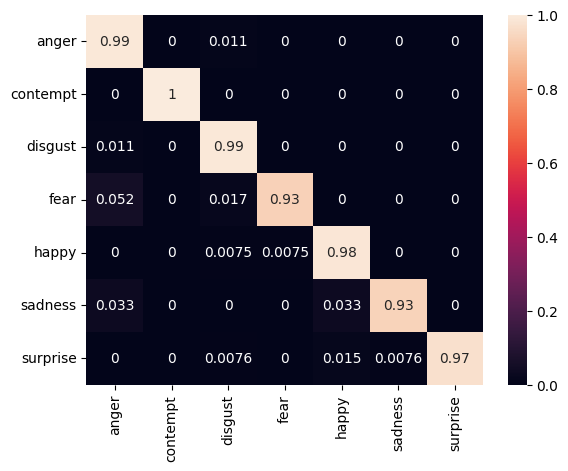

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(ground_truth, predictions , normalize='true')

cm = pd.DataFrame(cm, index = [i for i in single_classes],
                  columns = [i for i in single_classes])

sns.heatmap(cm, annot=True)

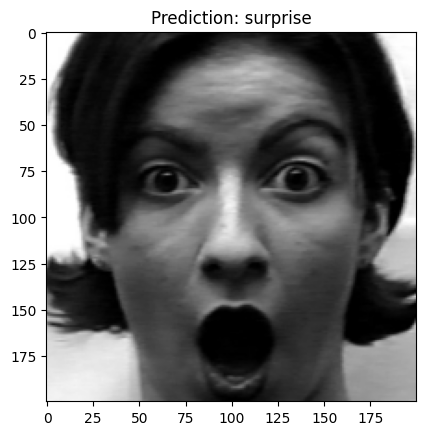

In [ ]:
path = "/content/gdrive/MyDrive/ColabData/emotion_recognition/cohn-kanade-images/S010/002/S010_002_00000014.png"
face = get_face_frame(path, resize_shape=(200,200))

predictions = model.predict(np.expand_dims(face, axis=0))
top_class = single_classes[predictions[0].argmax()]

plt.imshow(face)
plt.title(f"Prediction: {top_class}")
plt.show()

<br>

Saving the model

In [ ]:
from tensorflow.keras.models import save_model

filepath = f"{project_path}/models/single_output_model"
save_model(model, filepath)

1/1 [==============================] - 2s 2s/step
(200, 200, 3)


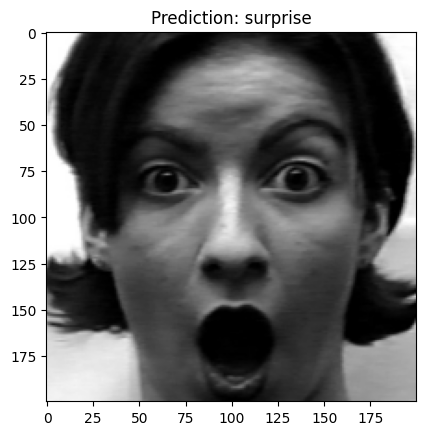

In [ ]:
from tensorflow.keras.models import load_model

filepath = f"{project_path}/models/single_output_model"
loaded_model = load_model(filepath)

path = "/content/gdrive/MyDrive/ColabData/emotion_recognition/cohn-kanade-images/S010/002/S010_002_00000014.png"
face = get_face_frame(path, resize_shape=(200,200))

predictions = loaded_model.predict(np.expand_dims(face, axis=0))
top_class = single_classes[predictions[0].argmax()]

print(face.shape)
plt.imshow(face)
plt.title(f"Prediction: {top_class}")
plt.show()

<br>

Try prediction on a colored image

(200, 200, 3)
1/1 [==============================] - 0s 373ms/step


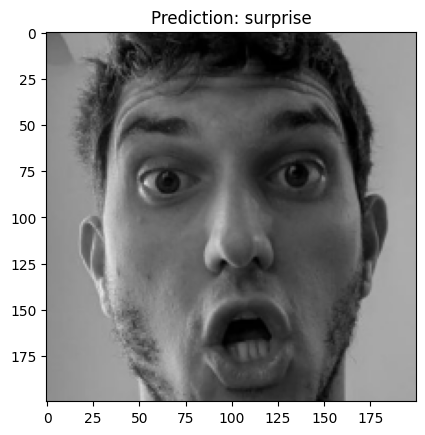

In [ ]:
# 1) get the colored image
path = "/content/gdrive/MyDrive/ColabData/emotion_recognition/prova.jpg"
face = get_face_frame(path, resize_shape=(200,200))

# 2) transform it to grayscale
face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)

# 3) repeat on three channels
face = face.reshape((face.shape[0], face.shape[1], 1))
face = np.repeat(face, 3, axis=2)
print(face.shape)

predictions = loaded_model.predict(np.expand_dims(face, axis=0))
top_class = single_classes[predictions[0].argmax()]

plt.imshow(face)
plt.title(f"Prediction: {top_class}")
plt.show()

## Multi-output model

Building a model that simultaneously recognize the emotion and the Action Units present in a facial image

In [ ]:
def build_multi_output_model(img_shape, num_classes, freeze_weights=False, verbose=0):
    inputs = layers.Input(shape=img_shape)
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze/Unfreeze the pretrained weights
    if freeze_weights:
      model.trainable = freeze_weights
    else:
      # unfreezing the top 20 layers while leaving BatchNorm layers frozen
      for layer in model.layers[-20:]:
          if not isinstance(layer, layers.BatchNormalization):
              layer.trainable = True

    # Attach head
    x = layers.GlobalAveragePooling2D(name="global_pooling")(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=0.2, name="dropout")(x)

    # output layer to detect the emotion
    outputs, losses = [], {}
    emotion_output = layers.Dense(num_classes, activation="softmax", name="emotion_output")(x)
    outputs.append(emotion_output)
    losses["emotion_output"] = "categorical_crossentropy"

    # an output layer for each possible Action Unit
    possible_aus = [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 9.0, 12.0, 14.0, 15.0, 16.0, 20.0, 23.0, 26.0]
    for au in possible_aus:
      outputs.append(layers.Dense(1, activation="sigmoid", name=f"AU{int(au)}_output")(x))
      losses[f"AU{int(au)}_output"] = "binary_crossentropy"

    model = tf.keras.Model(inputs, outputs, name="EfficientNet_multi_output")

    if freeze_weights:
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)   # large learning rate
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)   # low learning rate

    model.compile(optimizer=optimizer, loss=losses, metrics=["accuracy"])

    if verbose > 0: print(model.summary())

    return model


img_shape = train_X[0].shape
build_multi_output_model(img_shape, num_classes=len(single_classes), freeze_weights=False, verbose=1)

16719872/16705208 [==============================] - 0s 0us/step
Model: "EfficientNet_multi_output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 200, 200, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 200, 200, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_con

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
train_single_Y_ohe = enc.fit_transform(train_single_Y.reshape(-1, 1)).toarray()

print(single_classes)
print(train_single_Y[0], "->", train_single_Y_ohe[0])

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
disgust -> [0. 0. 1. 0. 0. 0. 0.]


In [ ]:
print(train_multi_Y[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
from sklearn.model_selection import train_test_split

X, val_X, Y, val_Y, multi_Y, val_multi_Y = train_test_split(train_X, train_single_Y_ohe, train_multi_Y, test_size=0.10, random_state=42)

In [ ]:
model = build_multi_output_model(img_shape, num_classes=len(single_classes), freeze_weights=False)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

gt = [Y]  # emotion one-hot-encoded labels
for i in range(len(multi_Y[0])): gt.append(multi_Y[:,i])   # Action Units binary labels

val_gt = [val_Y]
for i in range(len(val_multi_Y[0])): val_gt.append(val_multi_Y[:,i])

model.fit(x=X, y=gt, validation_data=(val_X, val_gt), epochs=100, verbose=1, callbacks=[early_stopping])

Epoch 1/100
166/166 [==============================] - 48s 287ms/step - loss: 6.3181 - emotion_output_loss: 0.5816 - AU1_output_loss: 0.2858 - AU2_output_loss: 0.2973 - AU4_output_loss: 0.3228 - AU5_output_loss: 0.3617 - AU6_output_loss: 0.2807 - AU7_output_loss: 0.4657 - AU9_output_loss: 0.4256 - AU12_output_loss: 0.2567 - AU14_output_loss: 0.4447 - AU15_output_loss: 0.5077 - AU16_output_loss: 0.5570 - AU20_output_loss: 0.5036 - AU23_output_loss: 0.4700 - AU26_output_loss: 0.5572 - emotion_output_accuracy: 0.8018 - AU1_output_accuracy: 0.8750 - AU2_output_accuracy: 0.8741 - AU4_output_accuracy: 0.8610 - AU5_output_accuracy: 0.8495 - AU6_output_accuracy: 0.8828 - AU7_output_accuracy: 0.7776 - AU9_output_accuracy: 0.8018 - AU12_output_accuracy: 0.8986 - AU14_output_accuracy: 0.8264 - AU15_output_accuracy: 0.7576 - AU16_output_accuracy: 0.7214 - AU20_output_accuracy: 0.7638 - AU23_output_accuracy: 0.7831 - AU26_output_accuracy: 0.7179 - val_loss: 5.7418 - val_emotion_output_loss: 0.5599 

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(val_X)

In [ ]:
from sklearn.metrics import classification_report

preds = np.argmax(predictions[0], axis=1)
ground_truth = np.argmax(val_gt[0], axis=1)

print(classification_report(ground_truth, preds, target_names=single_classes))

              precision    recall  f1-score   support

       anger       1.00      0.99      0.99        95
    contempt       1.00      1.00      1.00        21
     disgust       0.95      0.99      0.97        88
        fear       0.97      0.98      0.97        58
       happy       0.97      0.99      0.98       133
     sadness       1.00      0.95      0.97        61
    surprise       1.00      0.97      0.98       132

    accuracy                           0.98       588
   macro avg       0.98      0.98      0.98       588
weighted avg       0.98      0.98      0.98       588



In [ ]:
for i in range(len(possible_aus)):
  preds = np.array(predictions[i+1]).reshape((-1))
  preds = (preds > 0.5)
  ground_truth = (np.array(val_gt[i+1]) > 0.5)

  print(f"\nAction Unit {possible_aus[i]}")
  print(classification_report(ground_truth, preds, target_names=["Not Present", "Present"]))
  print("********************************************************")


Action Unit 1.0
              precision    recall  f1-score   support

 Not Present       0.97      1.00      0.98       350
     Present       1.00      0.95      0.97       238

    accuracy                           0.98       588
   macro avg       0.98      0.97      0.98       588
weighted avg       0.98      0.98      0.98       588

********************************************************

Action Unit 2.0
              precision    recall  f1-score   support

 Not Present       0.99      1.00      0.99       416
     Present       0.99      0.98      0.99       172

    accuracy                           0.99       588
   macro avg       0.99      0.99      0.99       588
weighted avg       0.99      0.99      0.99       588

********************************************************

Action Unit 4.0
              precision    recall  f1-score   support

 Not Present       0.98      0.99      0.99       353
     Present       0.99      0.97      0.98       235

    accuracy     

In [ ]:
from tensorflow.keras.models import save_model

filepath = f"{project_path}/models/multi_output_model"
save_model(model, filepath)

In [ ]:
from tensorflow.keras.models import load_model

filepath = f"{project_path}/models/multi_output_model"
loaded_model = load_model(filepath)

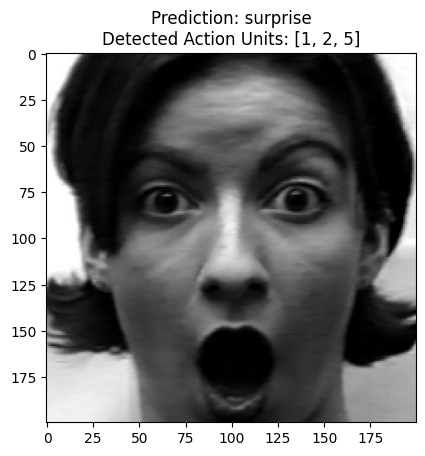

In [ ]:
path = "/content/gdrive/MyDrive/ColabData/emotion_recognition/cohn-kanade-images/S010/002/S010_002_00000014.png"
face = get_face_frame(path, resize_shape=(200,200))

predictions = loaded_model.predict(np.expand_dims(face, axis=0))

top_class = single_classes[np.argmax(predictions[0], axis=1)[0]]

pred_aus = []
for i in range(len(possible_aus)):
  if predictions[i+1] > 0.5:         # i+1 because in predictions[0] there is the emotion-based prediction
    pred_aus.append(int(possible_aus[i]))

plt.imshow(face)
plt.title(f"Prediction: {top_class}\nDetected Action Units: {pred_aus}")
plt.show()

![](https://www.researchgate.net/publication/303755395/figure/tbl1/AS:388516300247054@1469640912752/Set-of-action-units-needed-for-basic-emotions.png)